In [1]:
import os
import cv2
import shutil
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras

import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
#cek apakah terdapat GPU atau tidak
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
tf.test.is_built_with_cuda()

True

## Business, Data Understanding & Data Anaysis

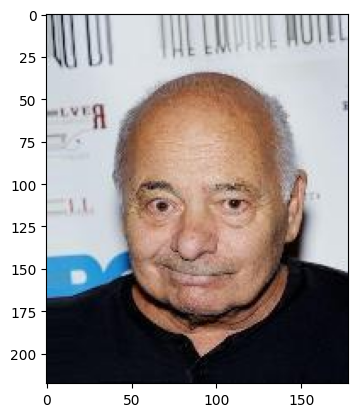

In [7]:
img = mpimg.imread('Dataset/Images/000051.jpg')
imgplot = plt.imshow( img )
plt.show()

Gender classification menggunakan deep learning bertujuan untuk mengidentifikasi dan memisahkan antara karakteristik yang berkaitan dengan jenis kelamin dalam data, seperti suara, gambar wajah, atau teks. Hal ini dapat digunakan dalam berbagai konteks, seperti:

1. **Analisis Sentimen**: Dalam analisis sentimen, mengetahui jenis kelamin pembicara bisa menjadi informasi tambahan yang berguna dalam memahami konteks dan nuansa dari teks yang dihasilkan.

2. **Pengenalan Wajah**: Dalam sistem pengenalan wajah, pengenalan jenis kelamin dapat membantu dalam mempersempit kandidat-kandidat yang cocok saat mencocokkan wajah dengan basis data yang ada.

3. **Keamanan**: Dalam sistem keamanan, seperti pengawasan video, mengenali jenis kelamin seseorang dapat memberikan informasi tambahan untuk mengidentifikasi individu secara lebih akurat.

4. **Pemasaran**: Dalam analisis pemasaran, memahami demografi audiens, termasuk jenis kelamin, dapat membantu dalam menyesuaikan dan menargetkan pesan dan produk secara lebih efektif.

Tujuan utamanya adalah untuk meningkatkan pemahaman dan pengolahan data dengan mengklasifikasikan jenis kelamin secara otomatis, yang dapat digunakan dalam berbagai aplikasi dari yang bersifat sosial hingga keamanan. Dengan menggunakan deep learning, model dapat belajar fitur-fitur yang paling diskriminatif untuk mengidentifikasi jenis kelamin dengan akurasi yang tinggi dari data yang kompleks dan beragam.

### Dataset

Dataset yang digunakan tersedia di Link berikut: https://drive.google.com/uc?id=1lw1Q7-MQtt9cYGM9Rks2mCdgDzZ12Neo 

Dataset ini berasal dari Dataset CelebA 

CelebFaces Attributes Dataset (CelebA) adalah dataset atribut wajah berskala besar dengan lebih dari 200 ribu gambar selebriti, masing-masing dengan 40 anotasi atribut. Gambar-gambar dalam dataset ini mencakup variasi pose yang besar dan kekacauan latar belakang.

File drive berisi :
1. Images = file gambar
2. list_attribute.txt = label gambar

Untuk mendapatkan label dari gambar, import list_attribute terlebih dahulu

In [11]:
# Displaying list attribute
df = pd.read_csv('Dataset/list_attribute.txt')
df

,202599
0,5_o_Clock_Shadow Arched_Eyebrows Attractive Ba...
1,000001.jpg -1 1 1 -1 -1 -1 -1 -1 -1 -1 -1 1...
2,000002.jpg -1 -1 -1 1 -1 -1 -1 1 -1 -1 -1 1...
3,000003.jpg -1 -1 -1 -1 -1 -1 1 -1 -1 -1 1 -1...
4,000004.jpg -1 -1 1 -1 -1 -1 -1 -1 -1 -1 -1 -1...
...,...
202595,202595.jpg -1 -1 1 -1 -1 -1 1 -1 -1 1 -1 -1...
202596,202596.jpg -1 -1 -1 -1 -1 1 1 -1 -1 1 -1 -1...
202597,202597.jpg -1 -1 -1 -1 -1 -1 -1 -1 1 -1 -1 -1...
202598,202598.jpg -1 1 1 -1 -1 -1 1 -1 1 -1 -1 -1...


kemudian akan dirapihkan file list_attribute ini agar mudah dibaca

In [13]:
header = df.iloc[0]
header

202599    5_o_Clock_Shadow Arched_Eyebrows Attractive Ba...
Name: 0, dtype: object

Tambahan kolom image_id

In [15]:
header_image_id = 'image_id '+ header

In [16]:
header_image_id

202599    image_id 5_o_Clock_Shadow Arched_Eyebrows Attr...
Name: 0, dtype: object

In [17]:
df.loc[0] = header_image_id

In [18]:
df.columns = df.iloc[0]

In [19]:
df.drop(0, inplace=True)

In [20]:
# remove own index with default index
df.reset_index(inplace = True, drop = True)

In [21]:
df

,image_id 5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young
0,000001.jpg -1 1 1 -1 -1 -1 -1 -1 -1 -1 -1 1...
1,000002.jpg -1 -1 -1 1 -1 -1 -1 1 -1 -1 -1 1...
2,000003.jpg -1 -1 -1 -1 -1 -1 1 -1 -1 -1 1 -1...
3,000004.jpg -1 -1 1 -1 -1 -1 -1 -1 -1 -1 -1 -1...
4,000005.jpg -1 1 1 -1 -1 -1 1 -1 -1 -1 -1 -1...
...,...
202594,202595.jpg -1 -1 1 -1 -1 -1 1 -1 -1 1 -1 -1...
202595,202596.jpg -1 -1 -1 -1 -1 1 1 -1 -1 1 -1 -1...
202596,202597.jpg -1 -1 -1 -1 -1 -1 -1 -1 1 -1 -1 -1...
202597,202598.jpg -1 1 1 -1 -1 -1 1 -1 1 -1 -1 -1...


pisahkan file list_attribute2.txt dengan koma, kemudian 

In [23]:
df.to_csv("Dataset/list_attribute2.txt",index=False)

In [24]:
# Buka file untuk dibaca
with open('Dataset/list_attribute2.txt', 'r') as file:
    lines = file.readlines()

# Mengubah format dan menulis kembali ke file
with open('Dataset/list_attribute2.txt', 'w') as file:
    for line in lines:
        # Menghapus whitespace tambahan dan memisahkan setiap kata
        words = line.strip().split()
        # Menggabungkan kata-kata dengan tanda koma di antara mereka
        new_line = ','.join(words)
        # Menulis baris baru ke file
        file.write(new_line + '\n')

In [7]:
df2 = pd.read_csv('Dataset/list_attribute2.txt', sep=',')

In [9]:
df2

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
202595,202596.jpg,-1,-1,-1,-1,-1,1,1,-1,-1,...,-1,1,1,-1,-1,-1,-1,-1,-1,1
202596,202597.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
202597,202598.jpg,-1,1,1,-1,-1,-1,1,-1,1,...,-1,1,-1,1,1,-1,1,-1,-1,1


Ubah kolom selain image_id menjadi bernilai integer

In [11]:
coba = df2.columns[df2.columns != 'image_id']
df2[coba].astype(int)
df2.replace(to_replace = -1, value = 0,inplace = True ) # Replacing '-1' values for '0', indicating the absence of attributes in the image
df2.head(10) # Displaying dataframe after changes

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
5,000006.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,1,1,0,1,0,0,1
6,000007.jpg,1,0,1,1,0,0,1,1,1,...,0,0,1,0,0,0,0,0,0,1
7,000008.jpg,1,1,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
8,000009.jpg,0,1,1,0,0,1,1,0,0,...,0,1,0,0,1,0,1,0,0,1
9,000010.jpg,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1


In [13]:
df2

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
202595,202596.jpg,0,0,0,0,0,1,1,0,0,...,0,1,1,0,0,0,0,0,0,1
202596,202597.jpg,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
202597,202598.jpg,0,1,1,0,0,0,1,0,1,...,0,1,0,1,1,0,1,0,0,1


In [15]:
# Creating 'gender' dataframe
gender = df2[['image_id','Male']]
gender.head(10)

,image_id,Male
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,1
3,000004.jpg,0
4,000005.jpg,0
5,000006.jpg,0
6,000007.jpg,1
7,000008.jpg,1
8,000009.jpg,0
9,000010.jpg,0


In [17]:
import os
images_folder = os.listdir('Dataset/Images')
gender['isExist'] = gender['image_id'].isin(images_folder)
gender

C:\Users\IBNU\AppData\Local\Temp\ipykernel_8440\258161087.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gender['isExist'] = gender['image_id'].isin(images_folder)


,image_id,Male,isExist
0,000001.jpg,0,False
1,000002.jpg,0,False
2,000003.jpg,1,False
3,000004.jpg,0,False
4,000005.jpg,0,False
...,...,...,...
202594,202595.jpg,0,False
202595,202596.jpg,1,False
202596,202597.jpg,1,False
202597,202598.jpg,0,False


In [19]:
gender.drop(gender[gender['isExist'] == False].index, inplace=True)
gender

C:\Users\IBNU\AppData\Local\Temp\ipykernel_8440\2128137754.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gender.drop(gender[gender['isExist'] == False].index, inplace=True)


,image_id,Male,isExist
50,000051.jpg,1,True
51,000052.jpg,1,True
64,000065.jpg,1,True
165,000166.jpg,1,True
197,000198.jpg,0,True
...,...,...,...
202319,202320.jpg,0,True
202339,202340.jpg,0,True
202346,202347.jpg,0,True
202356,202357.jpg,0,True


In [7]:
images_path = 'Dataset/Images'
splitted_folder = 'Splitted'
train_folder = os.path.join(splitted_folder, 'Train')
validation_folder = os.path.join(splitted_folder, 'Validation')
test_folder = os.path.join(splitted_folder, 'Test')

In [34]:
os.makedirs(train_folder, exist_ok=True)
os.makedirs(validation_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

In [35]:
for index, row in gender.iterrows():
    filename = row['image_id']
    gender_label = row['Male']

    if index % 10 < 8:
        splitted_folder = train_folder
    elif index % 10 == 8:
        splitted_folder = validation_folder
    else:
        splitted_folder = test_folder

    if gender_label == 0:
        gender_folder = os.path.join(splitted_folder, 'Female')
    else:
        gender_folder = os.path.join(splitted_folder, 'Male')

    os.makedirs(gender_folder, exist_ok=True)

    source_path = os.path.join(images_path, filename)
    destination_path = os.path.join(gender_folder, filename)

    print(f'Copying file {source_path} to {gender_folder}')
    shutil.copy(source_path, destination_path)

print('Splitting Datasets completed')

Copying file Dataset/Images\000051.jpg to Splitted\Train\Male
Copying file Dataset/Images\000052.jpg to Splitted\Train\Male
Copying file Dataset/Images\000065.jpg to Splitted\Train\Male
Copying file Dataset/Images\000166.jpg to Splitted\Train\Male
Copying file Dataset/Images\000198.jpg to Splitted\Train\Female
Copying file Dataset/Images\000201.jpg to Splitted\Train\Female
Copying file Dataset/Images\000240.jpg to Splitted\Test\Female
Copying file Dataset/Images\000282.jpg to Splitted\Train\Male
Copying file Dataset/Images\000352.jpg to Splitted\Train\Male
Copying file Dataset/Images\000409.jpg to Splitted\Validation\Male
Copying file Dataset/Images\000414.jpg to Splitted\Train\Male
Copying file Dataset/Images\000439.jpg to Splitted\Validation\Male
Copying file Dataset/Images\000444.jpg to Splitted\Train\Male
Copying file Dataset/Images\000474.jpg to Splitted\Train\Male
Copying file Dataset/Images\000525.jpg to Splitted\Train\Female
Copying file Dataset/Images\000545.jpg to Splitted\Tr

## Data Modeling

image_size = (ini adalah ukuran gambar yang akan masuk ke dalam arsitektur, sebesar 150x150 px)

batch_size = (jumlah batch, kita akan mencoba menggunakan nilai 32)

epochs = (mengacu pada satu kali melewati seluruh dataset pelatihan, menggunakan nilai 100)

In [9]:
image_size = (150, 150)
batch_size = 32
epochs = 100

### Train Datasets

Melakukan iterasi melalui dataset train_folder untuk membuat list batch yang berisi data latih dan labelnya. Data latih dan label kemudian disatukan menjadi dua list terpisah. Data kemudian ditumpuk (stacked) secara vertikal menjadi satu array besar, sedangkan label disatukan menjadi satu array menggunakan np.hstack.

In [11]:
train_datasets = image_dataset_from_directory(
    directory=train_folder,
    seed=random.randint(1, 1000),
    class_names=os.listdir(train_folder),
    image_size=image_size,
    batch_size=batch_size
)

Found 4029 files belonging to 2 classes.


In [13]:
train_data_batches = [(data.numpy(), labels.numpy()) for data, labels in train_datasets]
train_data, train_labels = zip(*train_data_batches)
train_data = np.vstack(train_data)
train_labels = np.hstack(train_labels)

### Validation Datasets

Melakukan iterasi melalui dataset validation_folder untuk membuat list batch yang berisi data dan labelnya. Data validasi dan label kemudian disatukan menjadi dua list terpisah. Data kemudian ditumpuk (stacked) secara vertikal menjadi satu array besar, sedangkan label disatukan menjadi satu array menggunakan np.hstack.

In [15]:
validation_datasets = image_dataset_from_directory(
    directory=validation_folder,
    seed=random.randint(1, 1000),
    class_names=os.listdir(validation_folder),
    image_size=image_size,
    batch_size=batch_size
)

Found 471 files belonging to 2 classes.


In [17]:
validation_data_batches = [(data.numpy(), labels.numpy()) for data, labels in validation_datasets]
validation_data, validation_labels = zip(*validation_data_batches)
validation_data = np.vstack(validation_data)
validation_labels = np.hstack(validation_labels)

### Test Datasets

Melakukan iterasi melalui dataset test_folder untuk membuat list batch yang berisi data tes dan labelnya. Data tes dan label kemudian disatukan menjadi dua list terpisah. Data kemudian ditumpuk (stacked) secara vertikal menjadi satu array besar, sedangkan label disatukan menjadi satu array menggunakan np.hstack.

In [19]:
test_datasets = image_dataset_from_directory(
    directory=test_folder,
    seed=random.randint(1, 1000),
    class_names=os.listdir(test_folder),
    image_size=image_size,
    batch_size=batch_size
)

Found 500 files belonging to 2 classes.


In [21]:
test_data_batches = [(data.numpy(), labels.numpy()) for data, labels in test_datasets]
test_data, test_labels = zip(*test_data_batches)
test_data = np.vstack(test_data)
test_labels = np.hstack(test_labels)

In [23]:
hp_opz = ['hyperband', 'RandomSearch', 'BayesianOptimization']

### Build the Model

Fungsi `build_InceptionV3` ini digunakan untuk membangun arsitektur model neural network menggunakan pre-trained model InceptionV3 sebagai bagian dasarnya. Berikut adalah penjelasan baris per baris:

1. `base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))`: Mendefinisikan model dasar (base model) menggunakan InceptionV3 yang telah dilatih sebelumnya dengan menggunakan gambar-gambar dari dataset ImageNet. Argumen `include_top=False` digunakan untuk menghilangkan lapisan teratas dari model, yang biasanya terdiri dari lapisan-lapisan fully connected yang digunakan untuk klasifikasi 1000 kelas ImageNet. `input_shape=(150, 150, 3)` menentukan bentuk input yang diharapkan untuk model.

2. `for layer in base_model.layers: layer.trainable = False`: Mengatur agar semua layer dari base model menjadi tidak dapat dilatih (non-trainable). Ini bertujuan agar parameter yang telah dilatih sebelumnya pada model InceptionV3 tetap tidak berubah saat kita melatih model yang baru.

3. `x = base_model.output`: Mengambil output dari base model.

4. `x = GlobalAveragePooling2D()(x)`: Menambahkan layer Global Average Pooling setelah output dari base model. Ini mengurangi dimensi spasial dari output menjadi satu dimensi dengan mengambil rata-rata dari setiap fitur dalam matriks.

5. `units = hp.Choice('num_units_1', values=[128, 256, 512])`: Menggunakan fungsi `hp.Choice` untuk memilih jumlah unit (neuron) untuk layer Dense selanjutnya. Ini adalah parameter yang akan dioptimalkan saat pencarian hyperparameter.

6. `x = Dense(units, activation='relu')(x)`: Menambahkan layer Dense dengan jumlah unit yang dipilih sebelumnya, dan menggunakan aktivasi ReLU.

7. `x = Dropout(0.5)(x)`: Menambahkan layer Dropout dengan tingkat dropout 0.5. Ini membantu mengurangi overfitting dengan secara acak mengabaikan sebagian unit selama proses pelatihan.

8. `outputs = Dense(1, activation='sigmoid')(x)`: Menambahkan layer output dengan satu unit dan aktivasi sigmoid, cocok untuk masalah klasifikasi biner.

9. `model = Model(inputs=base_model.input, outputs=outputs)`: Membuat model dari input dari base model hingga output yang baru saja dibuat.

10. `optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])` dan `learning_rate = hp.Choice('learning_rate', values=[1e-5, 1e-4, 1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.3])`: Menggunakan fungsi `hp.Choice` untuk memilih optimizer dan learning rate yang akan dioptimalkan saat pencarian hyperparameter.

11. `model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])`: Mengompilasi model dengan menggunakan binary crossentropy sebagai fungsi loss, optimizer yang dipilih, dan metrik akurasi untuk evaluasi model.

12. `return model`: Mengembalikan model yang telah dibuat.

In [43]:
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [123]:
def build_InceptionV3(hp):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    units = hp.Choice('num_units_1', values=[128, 256, 512])
    x = Dense(units, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x) 

    model = Model(inputs=base_model.input, outputs=outputs)

    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    learning_rate = hp.Choice('learning_rate', values=[1e-5, 1e-4, 1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.3])

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

### Hyperparameter Tuning

Tujuan dari Hyperparameter Tuning adalah untuk menemukan kombinasi hyperparameter yang optimal untuk arsitektur model yang diberikan sehingga mendapatkan performa terbaik. hyperparameter tuning yang digunakan antara lain :
1. Hyperband Tuning
2. Random Search Tuning
3. Bayesian Tuning

### Hyperband Tuning

Algoritma Hyperband memanfaatkan teknik penghematan sumber daya dengan menggabungkan pencarian grid (grid search) dengan penghentian dini (early stopping) dalam proses pencarian hyperparameter. Ini dilakukan dengan membagi sumber daya komputasi yang tersedia menjadi beberapa iterasi, dan setiap iterasi menggunakan jumlah model yang berkurang secara eksponensial. Iterasi awal menggunakan jumlah model yang lebih banyak dengan eksperimen yang lebih singkat, sementara iterasi lanjutan hanya melanjutkan eksperimen dengan model-model yang menunjukkan kinerja yang baik pada iterasi sebelumnya.


In [157]:
hyperband_tuner = kt.Hyperband(
    build_InceptionV3,
    objective='val_accuracy',
    max_epochs=epochs,
    factor=3,
    seed=42,
    directory='tuner',
    project_name=str(hp_opz[0])
)

Reloading Tuner from tuner\hyperband\tuner0.json


In [159]:
best_hyperband_param = {}
hyperband_tuner.search(train_datasets, validation_data=(validation_datasets), epochs=epochs, batch_size=batch_size, shuffle=True)

hyperband_results = hyperband_tuner.results_summary()

Results summary
Results in tuner\hyperband
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0044 summary
Hyperparameters:
optimizer: adam
learning_rate: 0.03
num_units_1: 512
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.7176221013069153

Trial 0046 summary
Hyperparameters:
optimizer: adam
learning_rate: 0.03
num_units_1: 256
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.6942675113677979

Trial 0039 summary
Hyperparameters:
optimizer: adam
learning_rate: 0.3
num_units_1: 512
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.6794055104255676

Trial 0049 summary
Hyperparameters:
optimizer: adam
learning_rate: 0.3
num_units_1: 256
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.675159215927124

Trial 0009 summary
Hyperparameters:
optimizer: adam
learning_rate: 1e-05
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round

Kode ini digunakan untuk mendapatkan parameter terbaik dari penyetelan menggunakan tuner Hyperband. Kemudian, model terbaik dibangun berdasarkan parameter ini dan dilatih dengan data pelatihan dan validasi. Selama pelatihan, ModelCheckpoint digunakan untuk menyimpan model terbaik berdasarkan kerugian pada data validasi, sementara EarlyStopping digunakan untuk menghentikan pelatihan jika tidak ada peningkatan dalam kerugian validasi.

In [161]:
best_hyperband_param = hyperband_tuner.get_best_hyperparameters(num_trials=1)[0]

cp = ModelCheckpoint('InceptionV3-with-{}-Optimization.h5'.format(hp_opz[0]), monitor='val_loss', save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=25)


best_hyperband_model = hyperband_tuner.hypermodel.build(best_hyperband_param)
best_hyperband_model = best_hyperband_model.fit(train_datasets, validation_data=(test_datasets), epochs=epochs,
                                                batch_size=batch_size, callbacks=[cp, early_stopping], shuffle=True)

Epoch 1/100
126/126 [==============================] - 18s 111ms/step - loss: 11.9015 - accuracy: 0.5609 - val_loss: 0.6440 - val_accuracy: 0.6360

Epoch 00001: val_loss improved from inf to 0.64395, saving model to InceptionV3-with-hyperband-Optimization.h5
Epoch 2/100
126/126 [==============================] - 9s 68ms/step - loss: 0.6623 - accuracy: 0.6088 - val_loss: 0.6481 - val_accuracy: 0.6080

Epoch 00002: val_loss did not improve from 0.64395
Epoch 3/100
126/126 [==============================] - 8s 65ms/step - loss: 0.6621 - accuracy: 0.6128 - val_loss: 0.6473 - val_accuracy: 0.6140

Epoch 00003: val_loss did not improve from 0.64395
Epoch 4/100
126/126 [==============================] - 9s 67ms/step - loss: 0.6473 - accuracy: 0.6185 - val_loss: 0.6331 - val_accuracy: 0.6180

Epoch 00004: val_loss improved from 0.64395 to 0.63306, saving model to InceptionV3-with-hyperband-Optimization.h5
Epoch 5/100
126/126 [==============================] - 10s 74ms/step - loss: 0.6531 - acc

### Random Search Tuning

Random search tuner adalah metode penyetelan hiperparameter yang menggunakan pendekatan acak untuk mencari kombinasi terbaik dari nilai hiperparameter. Ini berbeda dari metode penelusuran grid yang mencoba setiap kombinasi hiperparameter yang mungkin. Dalam random search tuner, kita menentukan rentang nilai yang mungkin untuk setiap hiperparameter, dan kemudian secara acak memilih beberapa kombinasi nilai untuk dievaluasi. Pendekatan ini sering lebih efisien daripada penelusuran grid karena dapat mengeksplorasi ruang hiperparameter dengan lebih efektif, terutama ketika ruang pencarian hiperparameter sangat besar.







In [127]:
randomsearch_tuner = kt.RandomSearch(
    build_InceptionV3,
    objective='val_accuracy',
    max_trials=10,
    seed=42,
    executions_per_trial=1,
    directory='tuner',
    project_name=str(hp_opz[1])
)
     

Reloading Tuner from tuner\RandomSearch\tuner0.json


In [129]:
best_randomsearch_param = {}
randomsearch_tuner.search(train_datasets, validation_data=(validation_datasets), epochs=epochs, batch_size=batch_size, shuffle=True)

randomsearch_results = randomsearch_tuner.results_summary()

Trial 10 Complete [00h 14m 14s]
val_accuracy: 0.6454352736473083

Best val_accuracy So Far: 0.7409766316413879
Total elapsed time: 02h 20m 38s
Results summary
Results in tuner\RandomSearch
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 03 summary
Hyperparameters:
num_units_1: 512
optimizer: adam
learning_rate: 0.3
Score: 0.7409766316413879

Trial 00 summary
Hyperparameters:
num_units_1: 256
optimizer: adam
learning_rate: 0.003
Score: 0.7388535141944885

Trial 04 summary
Hyperparameters:
num_units_1: 128
optimizer: rmsprop
learning_rate: 0.0001
Score: 0.7346072196960449

Trial 06 summary
Hyperparameters:
num_units_1: 256
optimizer: rmsprop
learning_rate: 0.003
Score: 0.7324841022491455

Trial 05 summary
Hyperparameters:
num_units_1: 128
optimizer: rmsprop
learning_rate: 0.3
Score: 0.7112526297569275

Trial 09 summary
Hyperparameters:
num_units_1: 128
optimizer: adam
learning_rate: 0.1
Score: 0.6454352736473083

Trial 02 summary
Hyperparameters:
num_units_1

In [135]:
best_randomsearch_param = randomsearch_tuner.get_best_hyperparameters(num_trials=1)[0]

cp = ModelCheckpoint('InceptionV3-with-{}-Optimization.h5'.format(hp_opz[1]), monitor='val_loss', save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=25)

best_randomsearch_model = randomsearch_tuner.hypermodel.build(best_randomsearch_param)
best_randomsearch_model = best_randomsearch_model.fit(test_datasets, validation_data=(test_datasets), epochs=epochs,
                                                batch_size=32, callbacks=[cp, early_stopping], shuffle=True)

Epoch 1/100
16/16 [==============================] - 6s 170ms/step - loss: 36.6222 - accuracy: 0.5620 - val_loss: 15.7538 - val_accuracy: 0.6100

Epoch 00001: val_loss improved from inf to 15.75377, saving model to InceptionV3-with-RandomSearch-Optimization.h5
Epoch 2/100
16/16 [==============================] - 2s 109ms/step - loss: 18.2495 - accuracy: 0.5780 - val_loss: 7.8998 - val_accuracy: 0.6500

Epoch 00002: val_loss improved from 15.75377 to 7.89984, saving model to InceptionV3-with-RandomSearch-Optimization.h5
Epoch 3/100
16/16 [==============================] - 2s 109ms/step - loss: 9.1863 - accuracy: 0.6260 - val_loss: 11.4901 - val_accuracy: 0.5920

Epoch 00003: val_loss did not improve from 7.89984
Epoch 4/100
16/16 [==============================] - 2s 109ms/step - loss: 6.3765 - accuracy: 0.6040 - val_loss: 1.5669 - val_accuracy: 0.7100

Epoch 00004: val_loss improved from 7.89984 to 1.56695, saving model to InceptionV3-with-RandomSearch-Optimization.h5
Epoch 5/100
16/16

### Bayesian Tuning


Penyetelan Bayesian adalah metode penyetelan hiperparameter yang menggunakan pendekatan probabilitas untuk menemukan kombinasi hiperparameter yang optimal. Ini berbeda dari metode penyetelan lainnya seperti penelusuran grid atau pencarian acak, di mana setiap kombinasi hiperparameter dievaluasi secara independen. Dalam penyetelan Bayesian, model probabilitas diperbarui secara iteratif saat evaluasi model dilakukan, dan informasi dari evaluasi sebelumnya digunakan untuk memandu pencarian ke arah yang lebih menjanjikan dalam ruang hiperparameter.

Dengan menggunakan teknik ini, penyetelan Bayesian dapat secara efisien mengeksplorasi ruang hiperparameter yang besar dan kompleks, sambil mengurangi jumlah percobaan yang diperlukan untuk menemukan kombinasi hiperparameter yang optimal. Ini membuatnya menjadi pilihan yang populer untuk penyetelan hiperparameter dalam pemodelan mesin dan pembelajaran mendalam.

In [137]:
bayesian_tuner = kt.BayesianOptimization(
    build_InceptionV3,
    objective='val_accuracy',
    max_trials=10,
    seed=42,
    directory='tuner',
    project_name=str(hp_opz[2])
)
     

In [139]:
best_bayesian_param = {}
bayesian_tuner.search(train_datasets, validation_data=(validation_datasets), epochs=epochs, batch_size=batch_size, shuffle=True)

bayesian_results = bayesian_tuner.results_summary()

Trial 10 Complete [00h 14m 03s]
val_accuracy: 0.7367303371429443

Best val_accuracy So Far: 0.7452229261398315
Total elapsed time: 02h 21m 56s
Results summary
Results in tuner\BayesianOptimization
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
num_units_1: 128
optimizer: rmsprop
learning_rate: 0.0001
Score: 0.7452229261398315

Trial 03 summary
Hyperparameters:
num_units_1: 512
optimizer: adam
learning_rate: 0.3
Score: 0.7430998086929321

Trial 06 summary
Hyperparameters:
num_units_1: 256
optimizer: rmsprop
learning_rate: 0.003
Score: 0.7388535141944885

Trial 09 summary
Hyperparameters:
num_units_1: 256
optimizer: rmsprop
learning_rate: 0.0001
Score: 0.7367303371429443

Trial 00 summary
Hyperparameters:
num_units_1: 256
optimizer: adam
learning_rate: 0.003
Score: 0.7261146306991577

Trial 05 summary
Hyperparameters:
num_units_1: 128
optimizer: rmsprop
learning_rate: 0.3
Score: 0.6050955653190613

Trial 02 summary
Hyperparameter

In [143]:
best_bayesian_param = bayesian_tuner.get_best_hyperparameters(num_trials=1)[0]

cp = ModelCheckpoint('Inceptionv3-{}-Optimization.h5'.format(hp_opz[2]), monitor='val_loss', save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=25)

best_bayesian_model = bayesian_tuner.hypermodel.build(best_bayesian_param)
best_bayesian_model = best_bayesian_model.fit(train_datasets, validation_data=(validation_datasets), epochs=epochs,
                                                batch_size=32, callbacks=[cp, early_stopping], shuffle=True)
     

Epoch 1/100
126/126 [==============================] - 12s 72ms/step - loss: 9.6285 - accuracy: 0.5689 - val_loss: 2.2249 - val_accuracy: 0.5924

Epoch 00001: val_loss improved from inf to 2.22494, saving model to Inceptionv3-BayesianOptimization-Optimization.h5
Epoch 2/100
126/126 [==============================] - 8s 64ms/step - loss: 1.0007 - accuracy: 0.5867 - val_loss: 0.6482 - val_accuracy: 0.5987

Epoch 00002: val_loss improved from 2.22494 to 0.64825, saving model to Inceptionv3-BayesianOptimization-Optimization.h5
Epoch 3/100
126/126 [==============================] - 8s 65ms/step - loss: 0.8473 - accuracy: 0.5860 - val_loss: 0.6376 - val_accuracy: 0.5987

Epoch 00003: val_loss improved from 0.64825 to 0.63756, saving model to Inceptionv3-BayesianOptimization-Optimization.h5
Epoch 4/100
126/126 [==============================] - 8s 65ms/step - loss: 0.7705 - accuracy: 0.5892 - val_loss: 0.6526 - val_accuracy: 0.5966

Epoch 00004: val_loss did not improve from 0.63756
Epoch 5/1

In [67]:
InceptionV3_random_search = load_model('InceptionV3-with-RandomSearch-Optimization.h5')

loss, accuracy = InceptionV3_random_search.evaluate(test_datasets)
print(f'InceptionV3 with Random Search Tuning model loss: {loss}, accuracy: {accuracy}')

16/16 [==============================] - 2s 55ms/step - loss: 0.3181 - accuracy: 0.8860
InceptionV3 with Random Search Tuning model loss: 0.318131685256958, accuracy: 0.8859999775886536


In [27]:
InceptionV3_Hyperband = load_model('InceptionV3-with-hyperband-Optimization.h5')

loss, accuracy = InceptionV3_Hyperband.evaluate(test_datasets)
print(f'InceptionV3 with Hyperband Tuning model loss: {loss}, accuracy: {accuracy}')

16/16 [==============================] - 2s 51ms/step - loss: 0.5645 - accuracy: 0.6520
InceptionV3 with Hyperband Tuning model loss: 0.5645347833633423, accuracy: 0.6520000100135803


In [29]:
InceptionV3_Bayesian = load_model('Inceptionv3-BayesianOptimization-Optimization.h5')

loss, accuracy = InceptionV3_Bayesian.evaluate(test_datasets)
print(f'InceptionV3 with Hyperband Tuning model loss: {loss}, accuracy: {accuracy}')

16/16 [==============================] - 2s 53ms/step - loss: 0.5763 - accuracy: 0.6660
InceptionV3 with Hyperband Tuning model loss: 0.5763006210327148, accuracy: 0.6660000085830688


### Evaluation Model

metrik evaluasi lain yang juga sering digunakan untuk mengevaluasi kinerja model InceptionV3 adalah confusion matrix

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       294
           1       0.93      0.78      0.85       206

    accuracy                           0.89       500
   macro avg       0.90      0.87      0.88       500
weighted avg       0.89      0.89      0.88       500



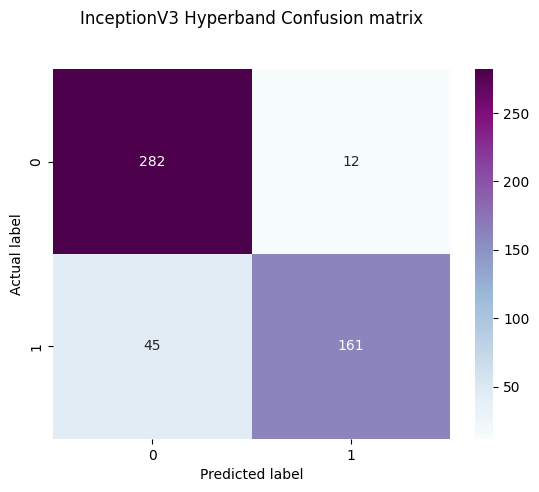

In [155]:
prediction = InceptionV3_random_search.predict(test_data)
cnf_matrix = confusion_matrix(test_labels, np.round(prediction))

p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="BuPu" ,fmt='g')
plt.title('InceptionV3 Hyperband Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(test_labels, np.round(prediction)))

              precision    recall  f1-score   support

           0       0.68      0.82      0.74       294
           1       0.63      0.45      0.52       206

    accuracy                           0.67       500
   macro avg       0.66      0.63      0.63       500
weighted avg       0.66      0.67      0.65       500



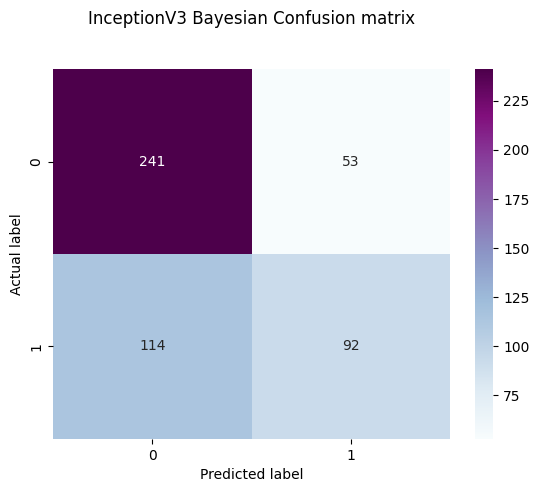

In [36]:
prediction = InceptionV3_Bayesian.predict(test_data)
cnf_matrix = confusion_matrix(test_labels, np.round(prediction))

p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="BuPu" ,fmt='g')
plt.title('InceptionV3 Bayesian Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(test_labels, np.round(prediction)))

              precision    recall  f1-score   support

           0       0.64      0.95      0.76       294
           1       0.75      0.23      0.36       206

    accuracy                           0.65       500
   macro avg       0.69      0.59      0.56       500
weighted avg       0.68      0.65      0.59       500



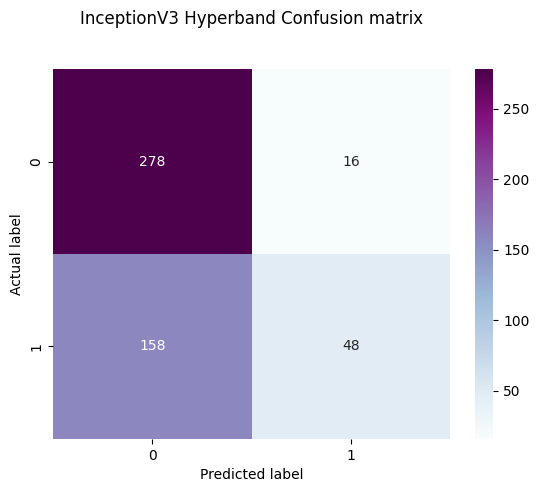

In [40]:
prediction = InceptionV3_Hyperband.predict(test_data)
cnf_matrix = confusion_matrix(test_labels, np.round(prediction))

p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="BuPu" ,fmt='g')
plt.title('InceptionV3 Hyperband Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(test_labels, np.round(prediction)))

hyperparameter yang paling bagus adalah Random Search dengan nilai akurasi sebesar 0.89

### Model Deployment

In [49]:
from keras.preprocessing.image import load_img

In [73]:
image_path = 'Splitted/Test/Male/001140.jpg'

img = tf.keras.utils.load_img(image_path, target_size=(150, 150))

img_array = tf.keras.utils.img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)

img_array /= 255.0

predictions_hyperband = InceptionV3_Hyperband.predict(img_array)
predictions_random_search = InceptionV3_random_search.predict(img_array)
predictions_bayesian = InceptionV3_Bayesian.predict(img_array)

threshold = 0.5

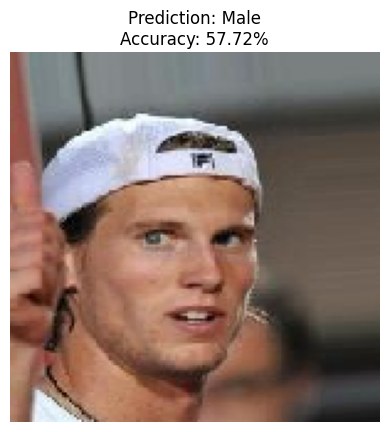

In [71]:
predicted_class = "Male" if predictions_hyperband[0][0] > threshold else "Female"
accuracy_percentage = predictions_hyperband[0][0] if predicted_class == "Male" else 1 - predictions_hyperband[0][0]

# Display the image
plt.imshow(img)
plt.axis('off')
plt.title(f'Prediction: {predicted_class}\nAccuracy: {accuracy_percentage * 100:.2f}%')
plt.show()

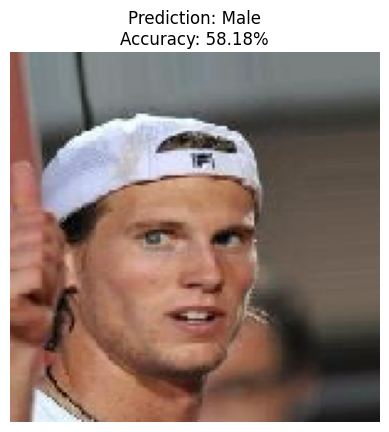

In [79]:
predicted_class = "Male" if predictions_random_search[0][0] > threshold else "Female"
accuracy_percentage = predictions_random_search[0][0] if predicted_class == "Male" else 1 - predictions_random_search[0][0]

# Display the image
plt.imshow(img)
plt.axis('off')
plt.title(f'Prediction: {predicted_class}\nAccuracy: {accuracy_percentage * 100:.2f}%')
plt.show()

In [81]:
predicted_class = "Male" if predictions_bayesian[0][0] > threshold else "Female"
accuracy_percentage = predictions_bayesian[0][0] if predicted_class == "Male" else 1 - predictions_Bayesian[0][0]

# Display the image
plt.imshow(img)
plt.axis('off')
plt.title(f'Prediction: {predicted_class}\nAccuracy: {accuracy_percentage * 100:.2f}%')
plt.show()

NameError: name 'predictions_Bayesian' is not defined